# Model 2 (D+3)

Alexandre

Here is a research notebook used for tests on predictiv models.

### Import librairies:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import datetime
from keras.utils import to_categorical
from keras.optimizers import RMSprop
from keras.models import load_model
from keras.callbacks import TensorBoard

Using TensorFlow backend.


Install the jupyter-tensorboard extension if needed:

https://github.com/lspvic/jupyter_tensorboard

In [2]:
#%pip install jupyter-tensorboard

Load Tensorboard:

In [3]:
%load_ext tensorboard

### Parameters:

In [4]:
#model
LOAD_MODEL = False 
MODEL_TO_LOAD_NAME = 'model.h5'
PATH_TO_MODELS = "Models/"

#dataset
CSV_PATH = "Datasets/completeDataset/"
CSV_NAME = "completeDataset.csv"
features_considered = ['IQ','pressure','wind_direction','wind_force','humidity','temperature']

### Import dataset and categorize the wind_direction:

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

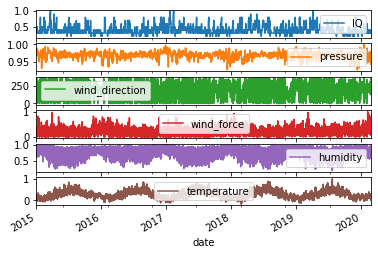

,IQ,pressure,wind_force,humidity,temperature,0,10,20,30,40,...,270,280,290,300,310,320,330,340,350,360
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.5,0.988013,0.126316,1.00,-0.007246,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00+00:00,0.5,0.986958,0.184211,0.95,-0.009662,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 06:00:00+00:00,0.5,0.987629,0.178947,0.94,-0.012077,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 09:00:00+00:00,0.5,0.987821,0.247368,0.85,0.028986,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 12:00:00+00:00,0.5,0.985999,0.336842,0.72,0.099034,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
df = pd.read_csv(CSV_PATH+CSV_NAME, header=0, delimiter=';')
df['date'] = pd.to_datetime(df['date'],utc=True)

features = df[features_considered]
features.index = df['date']

dataset_test = features.values

def higher_value(features,i):
    return[row[i] for row in dataset_test]

max_pressure = max(higher_value(dataset_test,1))
max_wind_force = max(higher_value(dataset_test,3))
max_temperature = max(higher_value(dataset_test, 5))

#normalize
features['IQ'] = features['IQ'].apply(lambda x: x/10)
features['pressure'] = features['pressure'].apply(lambda x: x/max_pressure)
features['wind_force'] = features['wind_force'].apply(lambda x: x/max_wind_force)
features['humidity'] = features['humidity'].apply(lambda x: x/100)
features['temperature'] = features['temperature'].apply(lambda x: (x-273.15)/(max_temperature-273.15)) 

features.plot(subplots=True)
plt.show()

#wind_direction to categorical
dummy = pd.get_dummies(features['wind_direction'])
windDummy = pd.DataFrame(columns = range(0,361,10))
windDummy[dummy.columns] = dummy.fillna(0)

features = pd.concat([features, windDummy], axis=1)
features = features.drop(columns=["wind_direction"])

features.head()

______________

### Create training data

#### Set the parameters:

In [6]:
#Params
nb_prev_measures_for_predict = 16 # = N in the following explanation

#### Create the train dataset: 
For each day we want to make a prediction of the air quality based on the N previous observation, sarting from the one at 12:00 of this day.

In [7]:
x_train = []
y_train = []
countRow=0

for indexRow, rowx in features.iterrows():
    # for each day we found with a value at 12:00
    if indexRow.hour == 12 and countRow >= nb_prev_measures_for_predict:
        try:
            # indexes for x (the range is inversed as our data are from the oldest to the newest)
            batchX = range(countRow, countRow - nb_prev_measures_for_predict, -1)
            # indexes for y
            batchY = [countRow+8,countRow+16,countRow+24]

            #application
            y_train.append(features.iloc[batchY]["IQ"].values)
            x_train.append(features.iloc[batchX].values)
        except:
            print("To long for ",indexRow)
    countRow+=1
    
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = y_train.reshape(y_train.shape[0],3,1)
print("x_train :",x_train.shape)
print("y_train :",y_train.shape)

To long for  2020-02-27 12:00:00+00:00
To long for  2020-02-28 12:00:00+00:00
To long for  2020-02-29 12:00:00+00:00
x_train : (1879, 16, 42)
y_train : (1879, 3, 1)


____________________________________

### Load the model or create it:

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import LSTM, Dense, Input
from keras.models import save_model

In [9]:
OPTIMIZER = RMSprop(0.0005)

if LOAD_MODEL: 
    model = load_model(PATH_TO_MODELS + MODEL_TO_LOAD_NAME)
    model.compile(OPTIMIZER, loss=LOSS)
else:
    # Model
    input_shape = (x_train.shape[-2],x_train.shape[-1])
    inp = Input(input_shape)
    _ = LSTM(512,input_shape=input_shape,name='LSTM_layer')(inp)
    _ = Dense(128,name="Intermediate_dense_layer")(_)
    
    outD1 = Dense(1,name="D1")(_)
    outD2 = Dense(1,name="D2")(_)
    outD3 = Dense(1,name="D3")(_)
    
    model = Model(inputs=[inp], outputs=[outD1, outD2, outD3])
    
    model.compile(optimizer=OPTIMIZER, loss={'D1': 'mse', 'D2': 'mse', 'D3': 'mse'}, metrics={'D1': 'mae', 'D2': 'mae', 'D3': 'mae'})
    model.summary()





__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 42)       0                                            
__________________________________________________________________________________________________
LSTM_layer (LSTM)               (None, 512)          1136640     input_1[0][0]                    
__________________________________________________________________________________________________
Intermediate_dense_layer (Dense (None, 128)          65664       LSTM_layer[0][0]                 
__________________________________________________________________________________________________
D1 (Dense)                      (None, 1)            129         Intermediate_dense_layer[0][0]   
__________________________________________________________________________________________________
D2 (De

### Train

In [10]:
EPOCHS = 40
kfoldsize = 5

callbackName = str('.\logs\\'+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")))
tensor_board = TensorBoard(callbackName)

for train_index,test_index in KFold(kfoldsize).split(x_train):
    x,x_val = x_train[train_index],x_train[test_index]
    y,y_val = y_train[train_index],y_train[test_index]
    
    hist = model.fit(x=x, y=[y[:,0],y[:,1],y[:,2]], validation_data=(x_val,[y_val[:,0],y_val[:,1],y_val[:,2]]),epochs=EPOCHS,callbacks = [tensor_board])
    save_model(model,"Models/model"+str(datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))+".h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1503 samples, validate on 376 samples


Epoch 1/40
1503/1503 [==============================] - 6s 4ms/step - loss: 0.0912 - D1_loss: 0.0275 - D2_loss: 0.0259 - D3_loss: 0.0378 - D1_mean_absolute_error: 0.1238 - D2_mean_absolute_error: 0.1223 - D3_mean_absolute_error: 0.1349 - val_loss: 0.0744 - val_D1_loss: 0.0275 - val_D2_loss: 0.0175 - val_D3_loss: 0.0295 - val_D1_mean_absolute_error: 0.1270 - val_D2_mean_absolute_error: 0.0931 - val_D3_mean_absolute_error: 0.1199
Epoch 2/40
1503/1503 [==============================] - 4s 3ms/step - loss: 0.0575 - D1_loss: 0.0187 - D2_loss: 0.0185 - D3_loss: 0.0203 - D1_mean_absolute_error: 0.1028 - D2_mean_absolute_error: 0.1042 - D3_mean_absolute_error: 0.1089 - val_loss: 0.0649 - val_D1_loss: 0.0286 - val_D2_loss: 0.0187 - val_D3_loss: 0.0176 - val_D1_mean_absolute_error: 0.1216 - val_D2_mean_absolute_error: 0.0943 - val_D3_mean_absolute_error

1503/1503 [==============================] - 5s 3ms/step - loss: 0.0372 - D1_loss: 0.0094 - D2_loss: 0.0130 - D3_loss: 0.0148 - D1_mean_absolute_error: 0.0740 - D2_mean_absolute_error: 0.0859 - D3_mean_absolute_error: 0.0928 - val_loss: 0.0536 - val_D1_loss: 0.0139 - val_D2_loss: 0.0198 - val_D3_loss: 0.0199 - val_D1_mean_absolute_error: 0.0887 - val_D2_mean_absolute_error: 0.0982 - val_D3_mean_absolute_error: 0.0991
Epoch 18/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0383 - D1_loss: 0.0099 - D2_loss: 0.0134 - D3_loss: 0.0150 - D1_mean_absolute_error: 0.0751 - D2_mean_absolute_error: 0.0861 - D3_mean_absolute_error: 0.0935 - val_loss: 0.0556 - val_D1_loss: 0.0134 - val_D2_loss: 0.0224 - val_D3_loss: 0.0198 - val_D1_mean_absolute_error: 0.0869 - val_D2_mean_absolute_error: 0.1154 - val_D3_mean_absolute_error: 0.1055
Epoch 19/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0367 - D1_loss: 0.0093 - D2_loss: 0.0129 - D3_loss: 0.0145 - D1_mea

Epoch 36/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0280 - D1_loss: 0.0074 - D2_loss: 0.0094 - D3_loss: 0.0113 - D1_mean_absolute_error: 0.0655 - D2_mean_absolute_error: 0.0742 - D3_mean_absolute_error: 0.0803 - val_loss: 0.0580 - val_D1_loss: 0.0142 - val_D2_loss: 0.0227 - val_D3_loss: 0.0211 - val_D1_mean_absolute_error: 0.0892 - val_D2_mean_absolute_error: 0.1132 - val_D3_mean_absolute_error: 0.1069
Epoch 37/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0273 - D1_loss: 0.0073 - D2_loss: 0.0089 - D3_loss: 0.0111 - D1_mean_absolute_error: 0.0658 - D2_mean_absolute_error: 0.0734 - D3_mean_absolute_error: 0.0804 - val_loss: 0.0564 - val_D1_loss: 0.0139 - val_D2_loss: 0.0219 - val_D3_loss: 0.0206 - val_D1_mean_absolute_error: 0.0852 - val_D2_mean_absolute_error: 0.1069 - val_D3_mean_absolute_error: 0.1069
Epoch 38/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0262 - D1_loss: 0.0068 - D2_loss: 0.0086 - D3_loss: 0.0

Epoch 15/40
1503/1503 [==============================] - 4s 3ms/step - loss: 0.0185 - D1_loss: 0.0056 - D2_loss: 0.0058 - D3_loss: 0.0071 - D1_mean_absolute_error: 0.0577 - D2_mean_absolute_error: 0.0597 - D3_mean_absolute_error: 0.0651 - val_loss: 0.0402 - val_D1_loss: 0.0097 - val_D2_loss: 0.0130 - val_D3_loss: 0.0175 - val_D1_mean_absolute_error: 0.0715 - val_D2_mean_absolute_error: 0.0880 - val_D3_mean_absolute_error: 0.0986
Epoch 16/40
1503/1503 [==============================] - 12s 8ms/step - loss: 0.0180 - D1_loss: 0.0055 - D2_loss: 0.0058 - D3_loss: 0.0068 - D1_mean_absolute_error: 0.0571 - D2_mean_absolute_error: 0.0592 - D3_mean_absolute_error: 0.0632 - val_loss: 0.0431 - val_D1_loss: 0.0117 - val_D2_loss: 0.0157 - val_D3_loss: 0.0157 - val_D1_mean_absolute_error: 0.0778 - val_D2_mean_absolute_error: 0.0944 - val_D3_mean_absolute_error: 0.0964
Epoch 17/40
1503/1503 [==============================] - 6s 4ms/step - loss: 0.0174 - D1_loss: 0.0053 - D2_loss: 0.0055 - D3_loss: 0.

Epoch 34/40
1503/1503 [==============================] - 11s 7ms/step - loss: 0.0095 - D1_loss: 0.0034 - D2_loss: 0.0027 - D3_loss: 0.0034 - D1_mean_absolute_error: 0.0457 - D2_mean_absolute_error: 0.0406 - D3_mean_absolute_error: 0.0450 - val_loss: 0.0466 - val_D1_loss: 0.0123 - val_D2_loss: 0.0161 - val_D3_loss: 0.0183 - val_D1_mean_absolute_error: 0.0819 - val_D2_mean_absolute_error: 0.0993 - val_D3_mean_absolute_error: 0.1050
Epoch 35/40
1503/1503 [==============================] - 10s 7ms/step - loss: 0.0092 - D1_loss: 0.0031 - D2_loss: 0.0030 - D3_loss: 0.0031 - D1_mean_absolute_error: 0.0438 - D2_mean_absolute_error: 0.0421 - D3_mean_absolute_error: 0.0439 - val_loss: 0.0444 - val_D1_loss: 0.0110 - val_D2_loss: 0.0155 - val_D3_loss: 0.0179 - val_D1_mean_absolute_error: 0.0783 - val_D2_mean_absolute_error: 0.0977 - val_D3_mean_absolute_error: 0.1017
Epoch 36/40
1503/1503 [==============================] - 6s 4ms/step - loss: 0.0090 - D1_loss: 0.0030 - D2_loss: 0.0029 - D3_loss: 0

Epoch 13/40
1503/1503 [==============================] - 18s 12ms/step - loss: 0.0070 - D1_loss: 0.0023 - D2_loss: 0.0022 - D3_loss: 0.0025 - D1_mean_absolute_error: 0.0371 - D2_mean_absolute_error: 0.0362 - D3_mean_absolute_error: 0.0382 - val_loss: 0.0145 - val_D1_loss: 0.0055 - val_D2_loss: 0.0041 - val_D3_loss: 0.0049 - val_D1_mean_absolute_error: 0.0589 - val_D2_mean_absolute_error: 0.0496 - val_D3_mean_absolute_error: 0.0542
Epoch 14/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0068 - D1_loss: 0.0022 - D2_loss: 0.0023 - D3_loss: 0.0023 - D1_mean_absolute_error: 0.0359 - D2_mean_absolute_error: 0.0367 - D3_mean_absolute_error: 0.0370 - val_loss: 0.0124 - val_D1_loss: 0.0036 - val_D2_loss: 0.0036 - val_D3_loss: 0.0053 - val_D1_mean_absolute_error: 0.0469 - val_D2_mean_absolute_error: 0.0487 - val_D3_mean_absolute_error: 0.0565
Epoch 15/40
1503/1503 [==============================] - 17s 11ms/step - loss: 0.0065 - D1_loss: 0.0022 - D2_loss: 0.0020 - D3_loss:

Epoch 32/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0038 - D1_loss: 0.0011 - D2_loss: 0.0014 - D3_loss: 0.0012 - D1_mean_absolute_error: 0.0263 - D2_mean_absolute_error: 0.0288 - D3_mean_absolute_error: 0.0270 - val_loss: 0.0145 - val_D1_loss: 0.0045 - val_D2_loss: 0.0045 - val_D3_loss: 0.0054 - val_D1_mean_absolute_error: 0.0526 - val_D2_mean_absolute_error: 0.0537 - val_D3_mean_absolute_error: 0.0589
Epoch 33/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0036 - D1_loss: 0.0011 - D2_loss: 0.0012 - D3_loss: 0.0013 - D1_mean_absolute_error: 0.0258 - D2_mean_absolute_error: 0.0274 - D3_mean_absolute_error: 0.0271 - val_loss: 0.0142 - val_D1_loss: 0.0047 - val_D2_loss: 0.0041 - val_D3_loss: 0.0054 - val_D1_mean_absolute_error: 0.0532 - val_D2_mean_absolute_error: 0.0506 - val_D3_mean_absolute_error: 0.0582
Epoch 34/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0035 - D1_loss: 0.0012 - D2_loss: 0.0011 - D3_loss: 0.0

Epoch 11/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0031 - D1_loss: 9.5224e-04 - D2_loss: 0.0010 - D3_loss: 0.0011 - D1_mean_absolute_error: 0.0238 - D2_mean_absolute_error: 0.0250 - D3_mean_absolute_error: 0.0257 - val_loss: 0.0052 - val_D1_loss: 0.0015 - val_D2_loss: 0.0017 - val_D3_loss: 0.0020 - val_D1_mean_absolute_error: 0.0303 - val_D2_mean_absolute_error: 0.0328 - val_D3_mean_absolute_error: 0.0349
Epoch 12/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0031 - D1_loss: 9.2338e-04 - D2_loss: 0.0010 - D3_loss: 0.0012 - D1_mean_absolute_error: 0.0235 - D2_mean_absolute_error: 0.0245 - D3_mean_absolute_error: 0.0264 - val_loss: 0.0048 - val_D1_loss: 0.0014 - val_D2_loss: 0.0016 - val_D3_loss: 0.0018 - val_D1_mean_absolute_error: 0.0296 - val_D2_mean_absolute_error: 0.0314 - val_D3_mean_absolute_error: 0.0333
Epoch 13/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0028 - D1_loss: 8.4528e-04 - D2_loss: 9.1284e-0

1503/1503 [==============================] - 5s 3ms/step - loss: 0.0021 - D1_loss: 6.2932e-04 - D2_loss: 7.1183e-04 - D3_loss: 7.6876e-04 - D1_mean_absolute_error: 0.0196 - D2_mean_absolute_error: 0.0207 - D3_mean_absolute_error: 0.0213 - val_loss: 0.0068 - val_D1_loss: 0.0019 - val_D2_loss: 0.0021 - val_D3_loss: 0.0028 - val_D1_mean_absolute_error: 0.0345 - val_D2_mean_absolute_error: 0.0375 - val_D3_mean_absolute_error: 0.0410
Epoch 30/40
1503/1503 [==============================] - 5s 3ms/step - loss: 0.0020 - D1_loss: 6.2115e-04 - D2_loss: 6.6807e-04 - D3_loss: 7.4551e-04 - D1_mean_absolute_error: 0.0196 - D2_mean_absolute_error: 0.0198 - D3_mean_absolute_error: 0.0212 - val_loss: 0.0068 - val_D1_loss: 0.0021 - val_D2_loss: 0.0019 - val_D3_loss: 0.0028 - val_D1_mean_absolute_error: 0.0353 - val_D2_mean_absolute_error: 0.0339 - val_D3_mean_absolute_error: 0.0416
Epoch 31/40
1503/1503 [==============================] - 4s 3ms/step - loss: 0.0022 - D1_loss: 6.9463e-04 - D2_loss: 6.549

1504/1504 [==============================] - 5s 3ms/step - loss: 0.0021 - D1_loss: 6.7736e-04 - D2_loss: 6.6591e-04 - D3_loss: 7.1191e-04 - D1_mean_absolute_error: 0.0201 - D2_mean_absolute_error: 0.0196 - D3_mean_absolute_error: 0.0203 - val_loss: 0.0020 - val_D1_loss: 5.6759e-04 - val_D2_loss: 7.3114e-04 - val_D3_loss: 7.1986e-04 - val_D1_mean_absolute_error: 0.0186 - val_D2_mean_absolute_error: 0.0215 - val_D3_mean_absolute_error: 0.0214
Epoch 8/40
1504/1504 [==============================] - 4s 3ms/step - loss: 0.0019 - D1_loss: 6.2604e-04 - D2_loss: 6.3403e-04 - D3_loss: 6.7125e-04 - D1_mean_absolute_error: 0.0193 - D2_mean_absolute_error: 0.0194 - D3_mean_absolute_error: 0.0199 - val_loss: 0.0017 - val_D1_loss: 5.4959e-04 - val_D2_loss: 4.8464e-04 - val_D3_loss: 6.5158e-04 - val_D1_mean_absolute_error: 0.0182 - val_D2_mean_absolute_error: 0.0176 - val_D3_mean_absolute_error: 0.0203
Epoch 9/40
1504/1504 [==============================] - 5s 3ms/step - loss: 0.0019 - D1_loss: 6.428

Epoch 25/40
1504/1504 [==============================] - 5s 3ms/step - loss: 0.0016 - D1_loss: 5.2091e-04 - D2_loss: 5.1629e-04 - D3_loss: 5.2746e-04 - D1_mean_absolute_error: 0.0177 - D2_mean_absolute_error: 0.0175 - D3_mean_absolute_error: 0.0174 - val_loss: 0.0026 - val_D1_loss: 8.9292e-04 - val_D2_loss: 8.5306e-04 - val_D3_loss: 8.6066e-04 - val_D1_mean_absolute_error: 0.0232 - val_D2_mean_absolute_error: 0.0228 - val_D3_mean_absolute_error: 0.0225
Epoch 26/40
1504/1504 [==============================] - 5s 3ms/step - loss: 0.0015 - D1_loss: 4.7445e-04 - D2_loss: 4.7290e-04 - D3_loss: 5.0619e-04 - D1_mean_absolute_error: 0.0166 - D2_mean_absolute_error: 0.0165 - D3_mean_absolute_error: 0.0172 - val_loss: 0.0028 - val_D1_loss: 0.0012 - val_D2_loss: 7.6654e-04 - val_D3_loss: 8.4376e-04 - val_D1_mean_absolute_error: 0.0280 - val_D2_mean_absolute_error: 0.0214 - val_D3_mean_absolute_error: 0.0218
Epoch 27/40
1504/1504 [==============================] - 5s 3ms/step - loss: 0.0015 - D1_l

________________

### See the training in tensorboard

In [11]:
#%tensorboard --logdir=./logs

Calculate the accuracy and mean error for each day [D+1, D+2, D+3]:

In [12]:
y_pred = model.predict(x_train)

y_train_visual = np.array(y_train)
y_pred_visual = np.array(y_pred).reshape(y_train_visual.shape)

Show the results in graphs:

Prediction of the air index quality


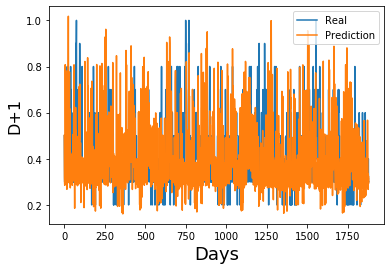

val_D1_loss 0.00089
val_D1_mean_absolute_error 0.02292
D1_loss 0.0004
D1_mean_absolute_error 0.01553


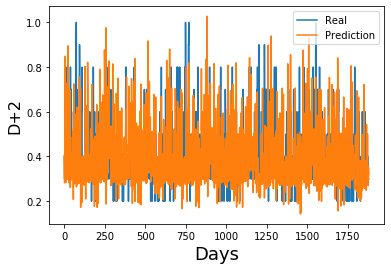

val_D2_loss 0.00103
val_D2_mean_absolute_error 0.02483
D2_loss 0.00045
D2_mean_absolute_error 0.01643


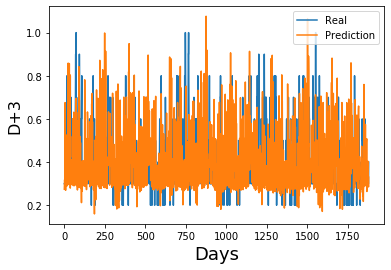

val_D3_loss 0.00132
val_D3_mean_absolute_error 0.02805
D3_loss 0.00045
D3_mean_absolute_error 0.01609


In [13]:
print('Prediction of the air index quality')
for plusDay in range(3):
    #plot predict    
    plt.plot(y_train_visual[:,plusDay], label='Real')
    plt.plot(y_pred_visual[:,plusDay], label='Prediction')
    plt.xlabel('Days', fontsize=18)
    plt.ylabel('D+'+str(plusDay+1), fontsize=16)
    plt.legend()
    plt.show()
    for measureName in hist.history:
        if "D"+str(plusDay+1) in measureName:
            print(measureName,round(hist.history[measureName][-1],5))